# Projeto - Classificação de Gênero Musical
# Project - Musical Genre Classification

## Paulo Victor Martins

### Importando Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import numpy as np
import librosa
from scipy.stats import kurtosis
from scipy.stats import skew
#sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import uniform, randint
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC


from sklearn.feature_selection import SelectKBest,f_classif


from sklearn.metrics import classification_report, confusion_matrix,f1_score,roc_auc_score,roc_curve

import sys
!{sys.executable} -m pip3 install xgboost
import xgboost as xgb
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)
%matplotlib inline

C:\Users\pv_ri\anaconda3\python.exe: No module named pip3


### Leitura dos dados e Seleção de Atributos

In [3]:
os.chdir('C:\\Users\\pv_ri\\Documents\\ML_Mestrado\\Trabalho_Final\\Data\\genres_original\\rock')

In [4]:
file_name='rock.00042.wav'
audio, sr = librosa.load(file_name ,duration=30)
IPython.display.Audio(audio, rate=sr)

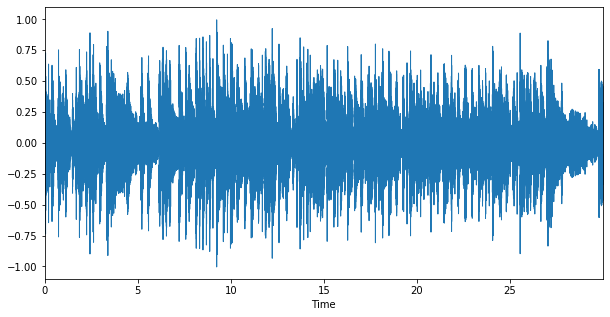

<Figure size 432x288 with 0 Axes>

In [11]:
# plot sample file
plt.figure(figsize=(10,5))
lplt.waveplot(audio)
plt.show()
plt.savefig("Audio.eps",format='eps')

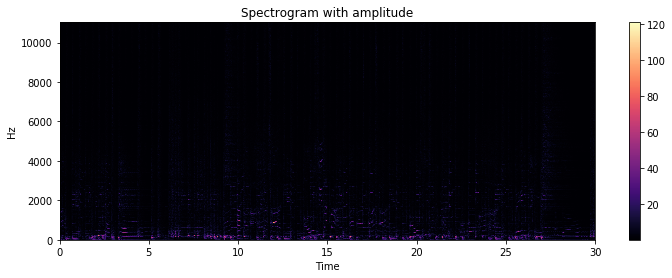

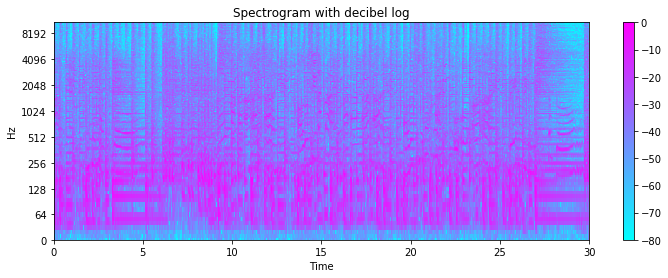

<Figure size 432x288 with 0 Axes>

In [5]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()
plt.savefig("STFT.jpg")

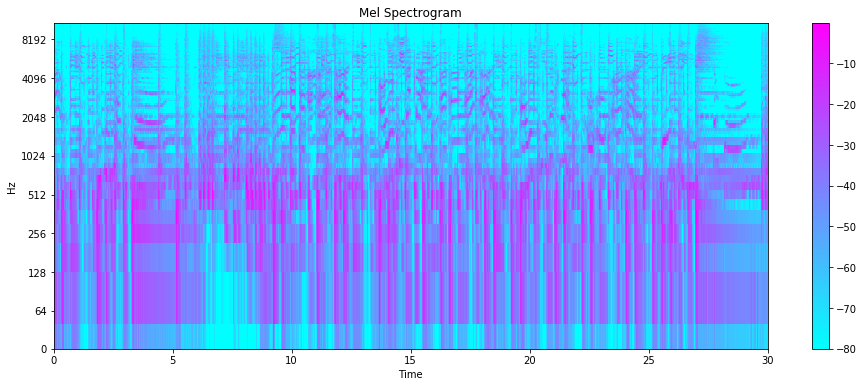

<Figure size 432x288 with 0 Axes>

In [6]:
mel_spec = librosa.feature.melspectrogram(audio, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()
plt.savefig("Mel_STFT.jpg")

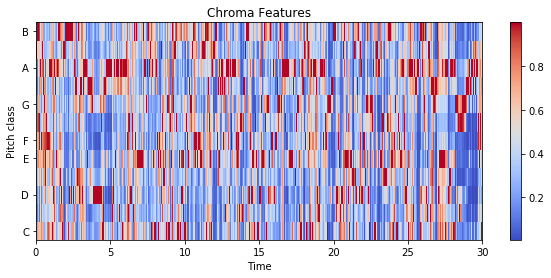

<Figure size 432x288 with 0 Axes>

In [10]:
chroma = librosa.feature.chroma_stft(audio, sr=sr)
plt.figure(figsize=(10,4))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()
plt.savefig("Chroma_Feat.png",format='png')

### Extração de Atributos

In [8]:
def extract_features(y,sr=22050,n_fft=1024,hop_length=512):
    '''
    Função para Extração de atributos dos sinais de áudio
    Entrada:
        y: Sinal de áudio
        sr: Frequência de Amostragem
        n_fft: Tamanho da Janela FFT
        hop_length: Tamanho do salto
    Saída:
    dict_agg_features: Dicionário com as features selecionadas
        
    
    '''
    features = {'chroma_cqt': librosa.feature.chroma_cqt(y, sr=sr, hop_length=hop_length).ravel(),
                'chroma_stft': librosa.feature.chroma_stft(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel(),
                'centroid': librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel(),
                'flux': librosa.onset.onset_strength(y=y, sr=sr).ravel(),
                'rmse': librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel(),
                'zcr': librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel(),
                'contrast': librosa.feature.spectral_contrast(y, sr=sr).ravel(),
                'bandwidth': librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel(),
                'flatness': librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel(),
                'rolloff': librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()}

    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft=n_fft, hop_length=hop_length, n_mfcc=20)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()

    # Get statistics from the vectors
    def get_feature_stats(features):
        result = {}
        for k, v in features.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_SNR'.format(k)]=np.mean(v)/np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result

    dict_agg_features = get_feature_stats(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y=y,sr=sr,hop_length=hop_length)[0]

    return dict_agg_features

In [9]:
''' 
arr_features=[]
os.chdir('C:\\Users\\Diretório')
genres = ['blues', 'classical' ,'country', 'disco', 'hiphop', 'jazz', 'metal','pop','reggae' ,'rock']
for idx,genre in enumerate(genres):
    for fname in os.listdir(genre):
        y, sr = librosa.load(genre+'//'+fname, duration=30)
        dict_features=extract_features(y=y,sr=sr)
        dict_features['label']=idx
        arr_features.append(dict_features)

df=pd.DataFrame(data=arr_features)
print(df.head())
print(df.shape)
#os.chdir('..')
os.chdir('C:\\Users\\Diretório')
df.to_csv('Extract_Dataset_30s.csv',index=False)
# O .csv foi criado para economizar tempo computacional quando precisamos rodar o alg várias vezes.
#Longa demora para gerar esses dados. É mais rápido ler o arquivo depois de pronto
'''

" \narr_features=[]\nos.chdir('C:\\Users\\pv_ri\\Documents\\ML_Mestrado\\Trabalho_Final\\Data\\genres_original')\ngenres = ['blues', 'classical' ,'country', 'disco', 'hiphop', 'jazz', 'metal','pop','reggae' ,'rock']\nfor idx,genre in enumerate(genres):\n    for fname in os.listdir(genre):\n        y, sr = librosa.load(genre+'//'+fname, duration=30)\n        dict_features=extract_features(y=y,sr=sr)\n        dict_features['label']=idx\n        arr_features.append(dict_features)\n\ndf=pd.DataFrame(data=arr_features)\nprint(df.head())\nprint(df.shape)\n#os.chdir('..')\nos.chdir('C:\\Users\\pv_ri\\Documents\\ML_Mestrado\\Trabalho_Final\\Data')\ndf.to_csv('Extract_Dataset_30s.csv',index=False)\n# O .csv foi criado para economizar tempo computacional quando precisamos rodar o alg várias vezes.\n#Longa demora para gerar esses dados. É mais rápido ler o arquivo depois de pronto\n"

In [10]:
os.chdir('C:\\Users\\pv_ri\\Documents\\ML_Mestrado\\Trabalho_Final\\Data')
df=pd.read_csv('Extract_Data_30s.csv')
spike_cols = [col for col in df.columns if 'mean' in col or 'std' in col or'max' in col or 'label' in col ]
df.drop(['flux_min'],axis=1,inplace=True)
#df= df[spike_cols]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 169 entries, centroid_max to label
dtypes: float64(168), int64(1)
memory usage: 1.3 MB


In [11]:
df.describe()

centroid_max  centroid_min  centroid_mean  centroid_std  \
count    999.000000    999.000000     999.000000    999.000000   
mean    4945.364598    768.759044    2100.445778    651.386235   
std     1572.040650    418.394567     698.078760    279.813687   
min     1066.082988      0.000000     533.912001     73.833180   
25%     3911.356168    461.337377    1521.037677    439.256782   
50%     4864.372713    673.560448    2111.333550    600.434067   
75%     6020.862776   1000.084389    2614.591559    814.294836   
max     8917.188266   2239.022284    4173.528440   1921.326691   

       centroid_kurtosis  centroid_skew    flux_max   flux_mean    flux_std  \
count         999.000000     999.000000  999.000000  999.000000  999.000000   
mean            2.163863       0.957675   12.355302    1.417430    1.555005   
std             3.813920       0.696058    5.429571    0.340392    0.677554   
min            -1.781259      -0.972680    1.514200    0.608809    0.163321   
25%             0.256420       0.520656    8.630243    1.162475    1.078017   
50%             1.267611       0.871925   11.448822    1.363921    1.450267   
75%             2.914604       1.289135   15.448601    1.631743    1.982980   
max            81.652454       8.014757   32.054024    2.451634    4.338383   

       flux_kurtosis  ...  mfcc_18_kurtosis  mfcc_18_skew  mfcc_19_max  \
count     999.000000  ...        999.000000    999.000000   999.000000   
mean       11.047460  ...          0.413997      0.177165    31.399978   
std        12.411862  ...          0.672627      0.330630    10.416977   
min         0.422275  ...         -0.690961     -0.837674     4.381364   
25%         5.739303  ...          0.001846     -0.049048    23.993258   
50%         8.290419  ...          0.249463      0.122391    30.117577   
75%        12.039629  ...          0.594453      0.358387    38.229502   
max       181.403460  ...          4.453073      1.542546    73.012314   

       mfcc_19_min  mfcc_19_mean  mfcc_19_std  mfcc_19_kurtosis  mfcc_19_skew  \
count   999.000000    999.000000   999.000000        999.000000    999.000000   
mean    -29.261599     -0.721178     8.914137          0.493418      0.150146   
std       7.663631      3.775675     2.362149          0.733557      0.343582   
min     -59.670074    -17.275305     3.474406         -1.220771     -1.210186   
25%     -34.197392     -3.039824     7.351531          0.038895     -0.074990   
50%     -28.412815     -0.748051     8.513161          0.315756      0.123091   
75%     -23.792041      1.538190    10.092271          0.747013      0.322469   
max      -9.491861     16.942514    27.319696          9.005470      1.518641   

            tempo       label  
count  999.000000  999.000000  
mean   120.974550    4.499499  
std     20.817509    2.875114  
min     69.837416    0.000000  
25%    103.359375    2.000000  
50%    117.453835    4.000000  
75%    135.999178    7.000000  
max    184.570312    9.000000  

[8 rows x 169 columns]

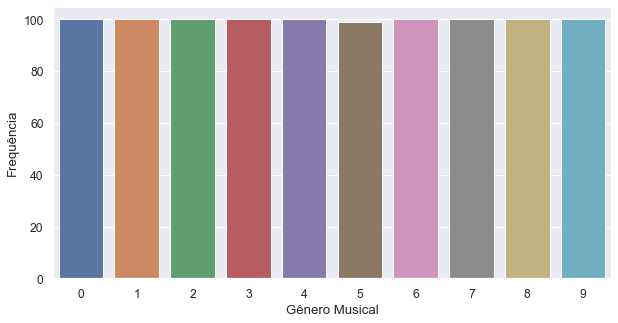

In [58]:
sns.set(font_scale=1.1)
plt.figure(figsize=(10,5))
ax = sns.countplot(x='label',data=df)
ax.set_xlabel('Gênero Musical')
ax.set_ylabel('Frequência')
plt.savefig('Hist.jpg',format='jpg')

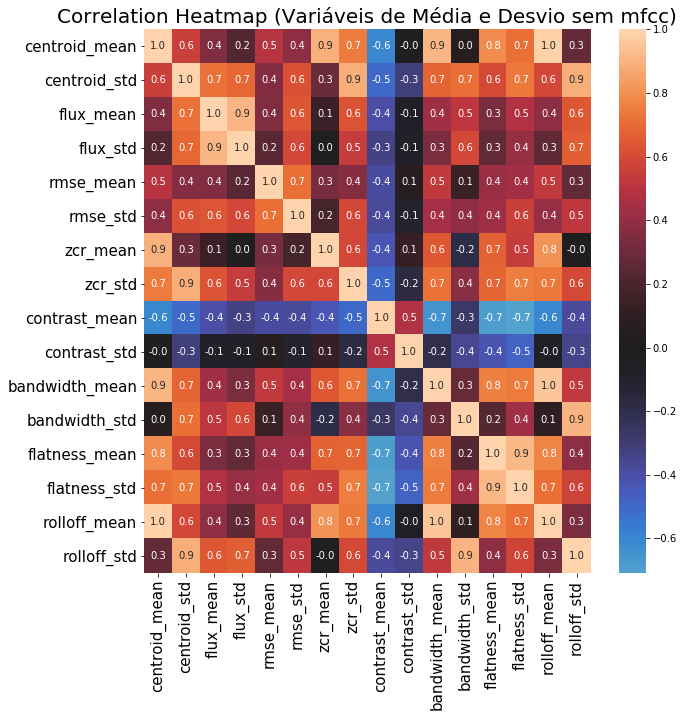

In [12]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mfcc' not in col and ('mean' in col or 'std' in col)]
corr = df[spike_cols].corr()

corr = df[spike_cols].corr(method='pearson')
sns.heatmap(corr,center=0,annot=True,fmt=".1f", xticklabels=True, yticklabels=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)

plt.title('Correlation Heatmap (Variáveis de Média e Desvio sem mfcc)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);
plt.savefig("Corr_Heatmap.jpg")

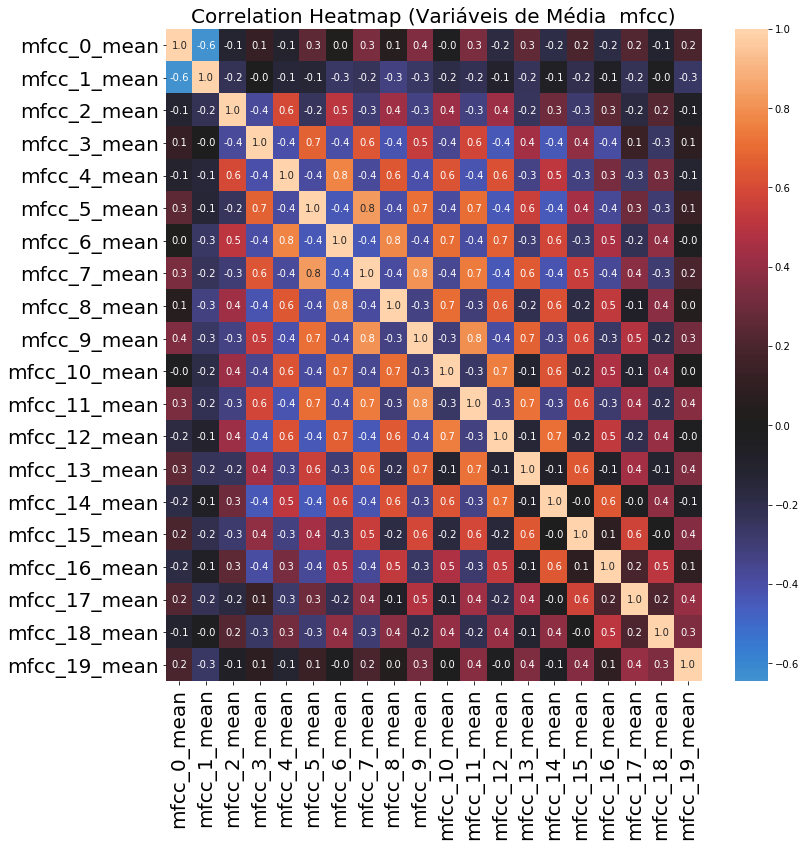

In [13]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mfcc' in col and 'mean' in col]
corr = df[spike_cols].corr(method='pearson')
sns.heatmap(corr,center=0,annot=True,fmt=".1f", xticklabels=True, yticklabels=True)
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.title('Correlation Heatmap (Variáveis de Média  mfcc)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);
 

plt.savefig("Corr_Heatmap_mfcc_mean.jpg")
#plt.savefig('pearson.jpg',format='jpg')
#plt.savefig('pearson.eps',format='eps')

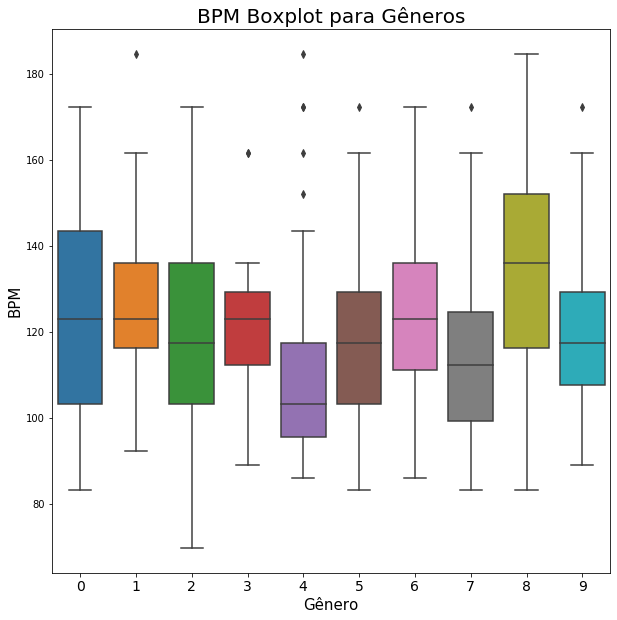

In [14]:
x = df[["label", "tempo"]]
genre_dict={0:'blues',1:'classical',2:'country',3:'disco',4:'hiphop',5:'jazz',6: 'metal',7:'pop',8:'reggae', 9:'rock'}
fig, ax = plt.subplots(figsize=(10, 10));
sns.boxplot(x ="label" , y = "tempo", data = x);

plt.title('BPM Boxplot para Gêneros', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Gênero", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.jpg")

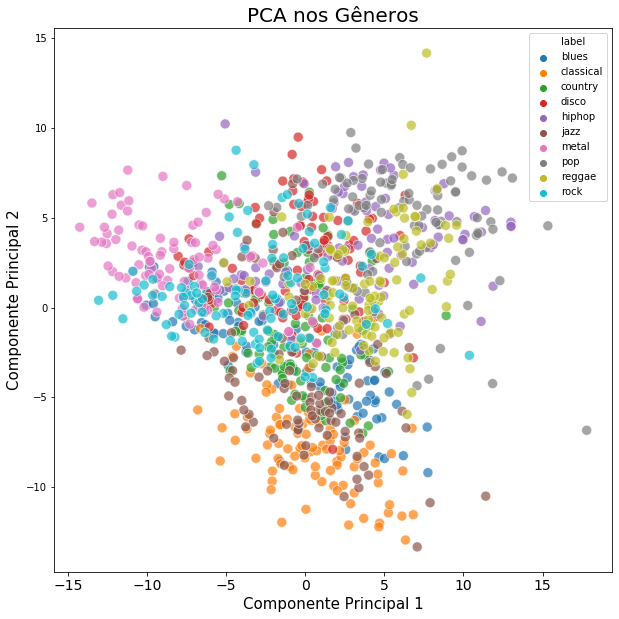

In [15]:

data = df.iloc[0:, 1:]
y = data['label']

y_str=y.map(genre_dict)
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
norm_data = StandardScaler().fit_transform(X)
X = pd.DataFrame(norm_data, columns = cols)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y_str], axis = 1)

plt.figure(figsize = (10, 10))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA nos Gêneros', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Componente Principal 1", fontsize = 15)
plt.ylabel("Componente Principal 2", fontsize = 15)
plt.savefig("PCA_Scattert.jpg")


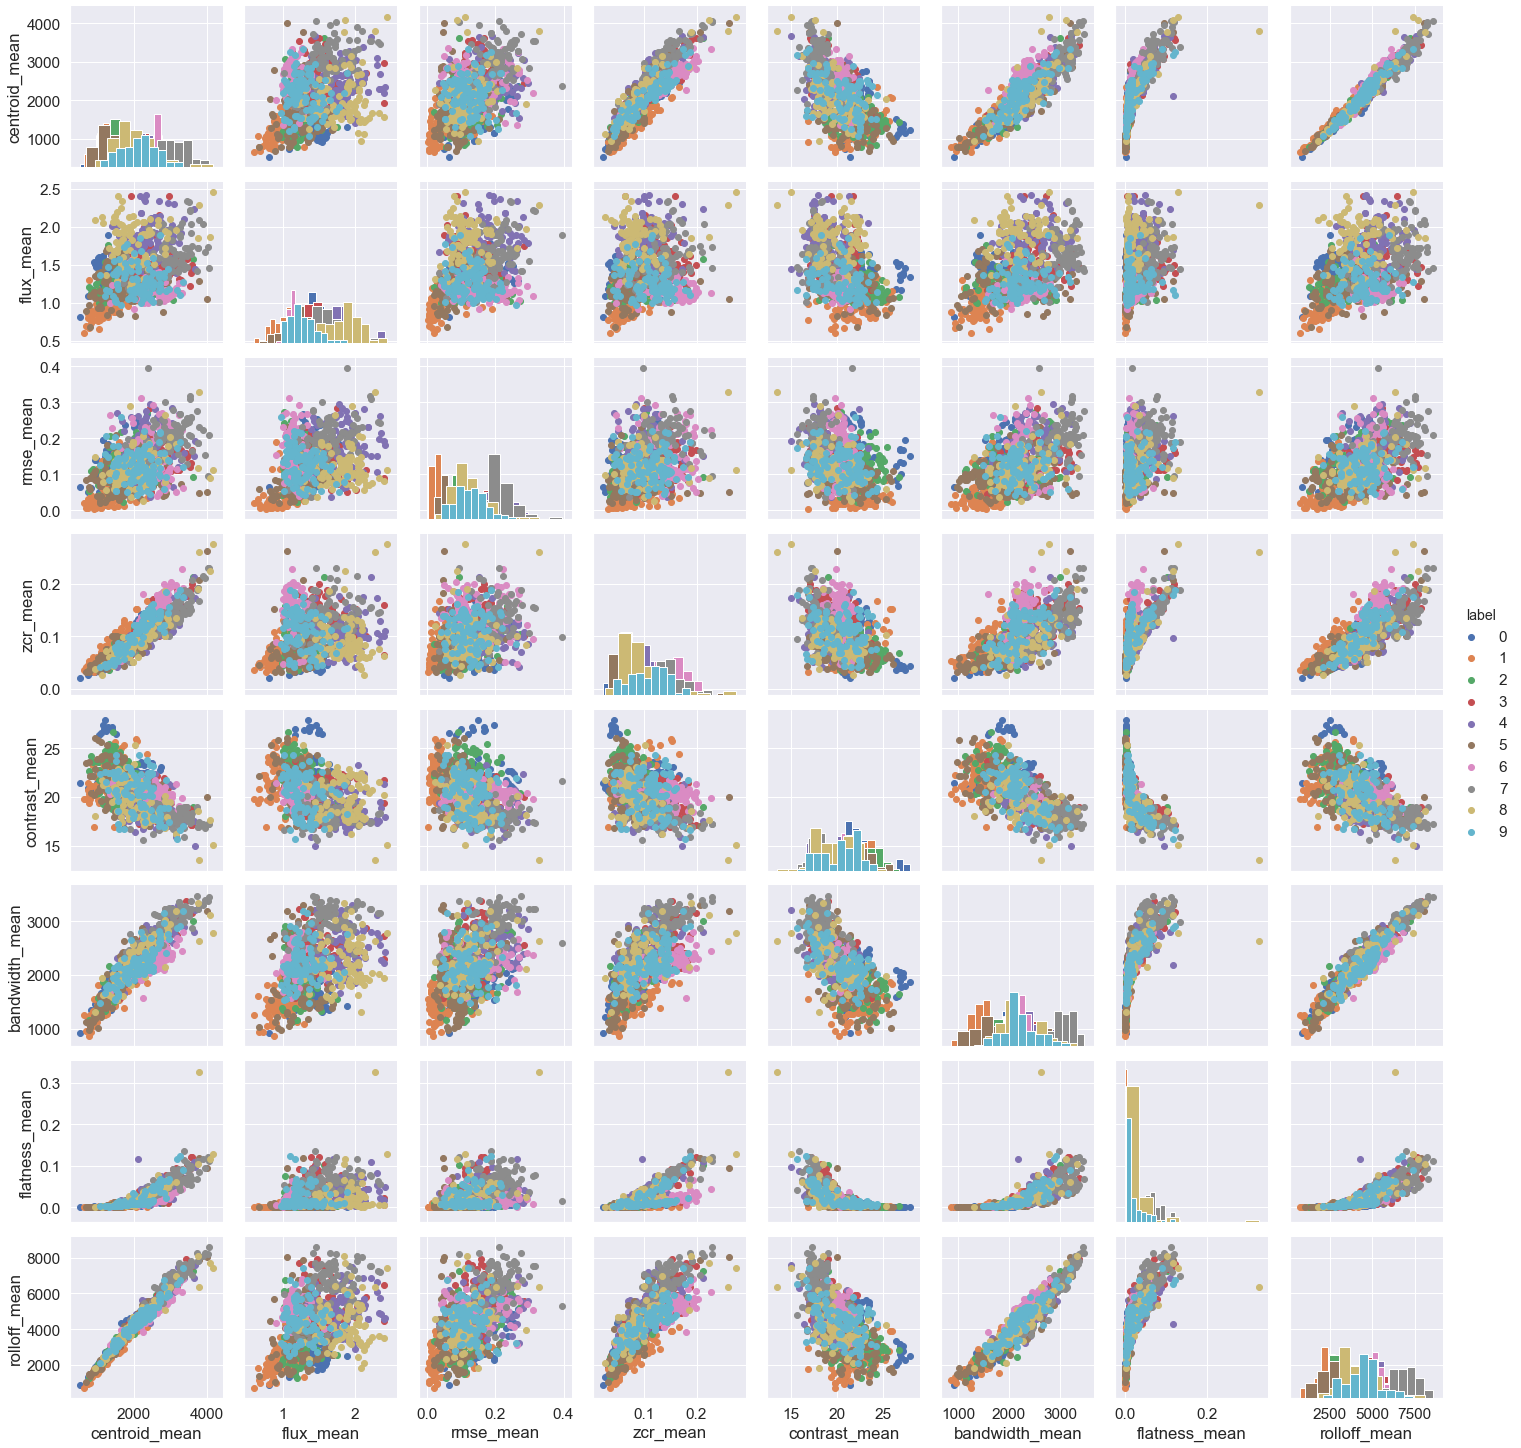

In [16]:
spike_cols = [col for col in df.columns if 'mean' in col and 'mfcc' not in col]
spike_cols.append('label')
df[spike_cols]
sns.set(font_scale=1.4)
g=sns.PairGrid(df[spike_cols],hue="label")
fig = plt.gcf()
fig.set_size_inches(20, 20)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(plt.scatter)
g.add_legend()
#
plt.savefig('pairPlot.jpg',format='jpg')
#plt.savefig('pairPlot.eps',format='eps')

In [17]:
# Verificar se tem valores NAN 
print("Colunas vazias",list(df.columns[df.isnull().any()]))

Colunas vazias []


### Dividindo o Dataset

In [18]:
## remove irrelevant columns
#encoded_y=pd.get_dummies(df['label']).to_numpy()

##genre_dict={0:'blues',1:'classical',2:'country',3:'disco',4:'hiphop',5:'jazz',6: 'metal',7:'pop',8:'reggae', 9:'rock'}
#genre_dict={'blues':0,'classical':1,'country':2,'disco':3,'hiphop':4,'jazz':5, 'metal':6,'pop':7,'reggae':8, 'rock':9}
#df['label']=df['label'].map(genre_dict)
#df.drop(['filename', 'length'], axis=1, inplace=True)
y = df['label']
X = df.loc[:, df.columns != 'label']


In [19]:
#Normalizando os dados e Dividindo o Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(699, 168)
(699,)
(300, 168)
(300,)


## Regressão Logística (Base)

In [20]:
model = Pipeline([('norm', StandardScaler()),
                 ('classifier' , LogisticRegression())])

# fit o modelo
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)

print('Acurácia Treino: ',model.score(X_train, y_train))
print('Acurácia Teste: ',model.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  1.0
Acurácia Teste:  0.7366666666666667
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        35
           1       0.83      1.00      0.91        20
           2       0.77      0.73      0.75        37
           3       0.72      0.55      0.62        33
           4       0.79      0.71      0.75        31
           5       0.88      0.85      0.87        34
           6       0.69      0.82      0.75        22
           7       0.76      0.85      0.80        26
           8       0.83      0.77      0.80        31
           9       0.43      0.48      0.45        31

    accuracy                           0.74       300
   macro avg       0.74      0.75      0.74       300
weighted avg       0.74      0.74      0.74       300

f1_score:  0.7359692286633682


### Permutação

Feature Importances using Permutation Importance


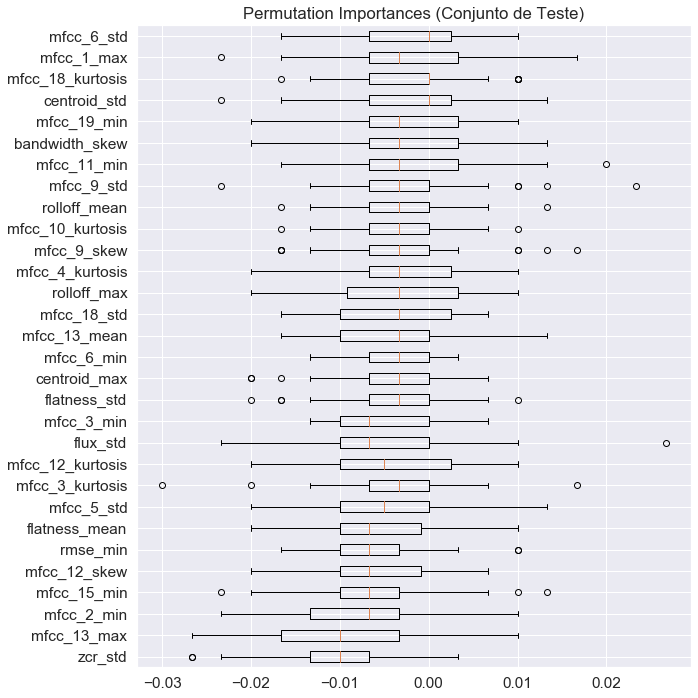

<Figure size 432x288 with 0 Axes>

In [21]:
from sklearn.inspection import permutation_importance
result =  permutation_importance(model, X_test, y_test, n_repeats=50,
                                random_state=42, n_jobs=2)
print("Feature Importances using Permutation Importance")
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,10))

ax.boxplot(result.importances[sorted_idx[:30]].T,
           vert=False, labels=X.columns[sorted_idx[:30]])
ax.set_title("Permutation Importances (Conjunto de Teste)")
fig.tight_layout()
plt.show()
perm_LR_col=list(X.columns[sorted_idx[:100]])
plt.savefig("Perm_Imp_LR.jpg",format='jpg')

In [22]:

#X_perm=df.iloc[:,sorted_idx[:50]]
#np.concatenate(np.array(X.columns[sorted_idx[:60]]), np.array(X.columns[sorted_idx[:60]]))

#perm_col=list(X.columns[sorted_idx[:50]])+list(X.columns[sorted_idx[:50]])
#lst=np.unique(lst)
#X_perm=df.loc[:,lst]

## KNN (Base)

In [23]:
model = Pipeline([('norm', StandardScaler()),
                 ('classifier' ,KNeighborsClassifier())])
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)

print('Acurácia Treino: ',model.score(X_train, y_train))
print('Acurácia Teste: ',model.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  0.8011444921316166
Acurácia Teste:  0.6933333333333334
              precision    recall  f1-score   support

           0       0.80      0.69      0.74        35
           1       0.76      0.95      0.84        20
           2       0.65      0.76      0.70        37
           3       0.54      0.64      0.58        33
           4       0.67      0.65      0.66        31
           5       0.90      0.79      0.84        34
           6       0.86      0.82      0.84        22
           7       0.63      0.73      0.68        26
           8       0.62      0.68      0.65        31
           9       0.61      0.35      0.45        31

    accuracy                           0.69       300
   macro avg       0.70      0.70      0.70       300
weighted avg       0.70      0.69      0.69       300

f1_score:  0.6897033665307656


## Árvores de Decisão(Base)

In [24]:
model = Pipeline([('norm', StandardScaler()),
                 ('classifier' ,DecisionTreeClassifier())])

model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)

print('Acurácia Treino: ',model.score(X_train, y_train))
print('Acurácia Teste: ',model.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  1.0
Acurácia Teste:  0.5033333333333333
              precision    recall  f1-score   support

           0       0.42      0.29      0.34        35
           1       0.61      0.95      0.75        20
           2       0.58      0.49      0.53        37
           3       0.33      0.39      0.36        33
           4       0.50      0.61      0.55        31
           5       0.57      0.35      0.44        34
           6       0.59      0.77      0.67        22
           7       0.71      0.58      0.64        26
           8       0.50      0.58      0.54        31
           9       0.33      0.32      0.33        31

    accuracy                           0.50       300
   macro avg       0.51      0.53      0.51       300
weighted avg       0.51      0.50      0.49       300

f1_score:  0.49421053040298774


## Árvores Aleatórias(Base)

In [25]:
model = Pipeline([('norm', StandardScaler()),
                 ('classifier' ,RandomForestClassifier())])
# fit o modelo
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)

print('Acurácia Treino: ',model.score(X_train, y_train))
print('Acurácia Teste: ',model.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  1.0
Acurácia Teste:  0.71
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        35
           1       0.77      1.00      0.87        20
           2       0.73      0.59      0.66        37
           3       0.68      0.58      0.62        33
           4       0.75      0.68      0.71        31
           5       0.90      0.82      0.86        34
           6       0.62      0.95      0.75        22
           7       0.64      0.69      0.67        26
           8       0.71      0.81      0.76        31
           9       0.54      0.48      0.51        31

    accuracy                           0.71       300
   macro avg       0.71      0.73      0.71       300
weighted avg       0.71      0.71      0.71       300

f1_score:  0.7058760457014346


## AdaBoost (Base)

In [26]:
model = Pipeline([('norm', StandardScaler()),
                 ('classifier' ,AdaBoostClassifier())])
# fit o modelo
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)

print('Acurácia Treino: ',model.score(X_train, y_train))
print('Acurácia Teste: ',model.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  0.20457796852646637
Acurácia Teste:  0.18333333333333332
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.60      0.75      0.67        20
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00        33
           4       0.13      1.00      0.22        31
           5       0.53      0.26      0.35        34
           6       0.00      0.00      0.00        22
           7       0.00      0.00      0.00        26
           8       0.00      0.00      0.00        31
           9       0.00      0.00      0.00        31

    accuracy                           0.18       300
   macro avg       0.13      0.20      0.12       300
weighted avg       0.11      0.18      0.11       300

f1_score:  0.10765700483091786


## GradientBoost (Base)

In [27]:
model = Pipeline([('norm', StandardScaler()),
                 ('classifier' ,GradientBoostingClassifier())])
# fit o modelo
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)

print('Acurácia Treino: ',model.score(X_train, y_train))
print('Acurácia Teste: ',model.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  1.0
Acurácia Teste:  0.74
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        35
           1       0.86      0.90      0.88        20
           2       0.72      0.78      0.75        37
           3       0.67      0.67      0.67        33
           4       0.71      0.71      0.71        31
           5       0.90      0.79      0.84        34
           6       0.74      0.91      0.82        22
           7       0.87      0.77      0.82        26
           8       0.73      0.77      0.75        31
           9       0.42      0.35      0.39        31

    accuracy                           0.74       300
   macro avg       0.74      0.75      0.74       300
weighted avg       0.74      0.74      0.74       300

f1_score:  0.7370291350858338


## XGBoost (Base)

In [28]:
model = Pipeline([('norm', StandardScaler()),
                 ('classifier' ,xgb.XGBClassifier())])
# fit o modelo
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)

print('Acurácia Treino: ',model.score(X_train, y_train))
print('Acurácia Teste: ',model.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

[02:10:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acurácia Treino:  1.0
Acurácia Teste:  0.7333333333333333
              precision    recall  f1-score   support

           0       0.70      0.89      0.78        35
           1       0.86      0.95      0.90        20
           2       0.84      0.57      0.68        37
           3       0.65      0.61      0.62        33
           4       0.79      0.71      0.75        31
           5       0.85      0.85      0.85        34
           6       0.72      0.95      0.82        22
           7       0.62      0.77      0.69        26
           8       0.80      0.77      0.79        31
           9       0.52      0.42      0.46        31

    accuracy                       

## SVM(Base)

In [29]:
model = Pipeline([('norm', StandardScaler()),
                 ('classifier' ,SVC())])
# fit o modelo
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
#y_pred_proba=model.predict_proba(X_test)

print('Acurácia Treino: ',model.score(X_train, y_train))
print('Acurácia Teste: ',model.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  0.9527896995708155
Acurácia Teste:  0.7833333333333333
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        35
           1       0.77      1.00      0.87        20
           2       0.78      0.76      0.77        37
           3       0.71      0.67      0.69        33
           4       0.86      0.77      0.81        31
           5       0.90      0.82      0.86        34
           6       0.72      0.95      0.82        22
           7       0.74      0.77      0.75        26
           8       0.86      0.81      0.83        31
           9       0.67      0.52      0.58        31

    accuracy                           0.78       300
   macro avg       0.78      0.80      0.78       300
weighted avg       0.78      0.78      0.78       300

f1_score:  0.7796977417643302


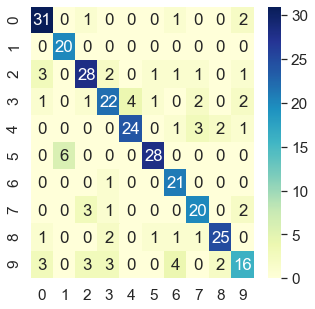

In [30]:
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu',ax=ax)
plt.savefig("CM_SVM_base.jpg",format='jpg')

### Com base nos resultados acima iremos formar um novo conjunto de dados utilizando o método de seleção de atributos KBest. Em seguida iremos testá-lo novamente usando os classificadores e comparar com os resultados anteriores.

### Se repetirá o mesmo processo de classificação, só que agora iremos utilizar o Dataset reduzido após a seleção e será usado GridSearch e validação cruzada com o objetivo de obter um modelo com hiperparâmetros ajustados e uma maior acurácia.

## Regressão Logística

In [31]:
pipe = Pipeline([('norm', StandardScaler()),('sel_feat', SelectKBest(score_func=f_classif)),('pca',PCA()),
                 ('classifier' , LogisticRegression())])


         
# Create param grid.

param_grid = [
    {'sel_feat__k':[150,120,80, 60,30],
     'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__solver' : ['liblinear','lbfgs']}
]

# Create grid search object
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
clf = GridSearchCV(pipe, param_grid = param_grid, cv = cv, scoring='accuracy', verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)
print("Parâmetros escolhidos ",best_clf.best_params_)
print(" Acurácia:",best_clf.best_score_)

Fitting 15 folds for each of 400 candidates, totalling 6000 fits
Parâmetros escolhidos  {'classifier': LogisticRegression(C=0.615848211066026), 'classifier__C': 0.615848211066026, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'sel_feat__k': 60}
 Acurácia: 0.7601610140459061


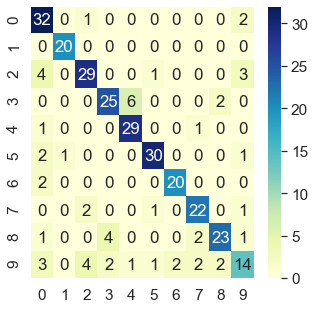

In [32]:
y_pred=best_clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu',ax=ax)

plt.savefig("CM_RL.jpg",format='jpg')

In [33]:
print('Acurácia Treino: ',best_clf.score(X_train, y_train))
print('Acurácia Teste: ',best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  0.9241773962804005
Acurácia Teste:  0.8133333333333334
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        35
           1       0.95      1.00      0.98        20
           2       0.81      0.78      0.79        37
           3       0.81      0.76      0.78        33
           4       0.81      0.94      0.87        31
           5       0.91      0.88      0.90        34
           6       0.91      0.91      0.91        22
           7       0.81      0.85      0.83        26
           8       0.85      0.74      0.79        31
           9       0.64      0.45      0.53        31

    accuracy                           0.81       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.81      0.81      0.81       300

f1_score:  0.8084091951099039


### KNN

In [34]:

pipe = Pipeline([('norm', StandardScaler()),('sel_feat', SelectKBest(score_func=f_classif)),('pca',PCA()),
                 ('classifier' ,KNeighborsClassifier())])
# Create param grid.

param_grid = [
    {'sel_feat__k':[150,120,80, 60,30],
     'classifier' : [KNeighborsClassifier()],
     'classifier__n_neighbors' : [3,5,7,10],
    'classifier__p' : [1,2],
    'classifier__weights' : ['uniform','distance']}
]

# Create grid search object
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
clf = GridSearchCV(pipe, param_grid = param_grid, cv = cv, scoring='accuracy', verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)
print("Parâmetros escolhidos ",best_clf.best_params_)
print(" Acurácia:",best_clf.best_score_)

Fitting 15 folds for each of 80 candidates, totalling 1200 fits
Parâmetros escolhidos  {'classifier': KNeighborsClassifier(n_neighbors=7, p=1, weights='distance'), 'classifier__n_neighbors': 7, 'classifier__p': 1, 'classifier__weights': 'distance', 'sel_feat__k': 80}
 Acurácia: 0.6991503939705377


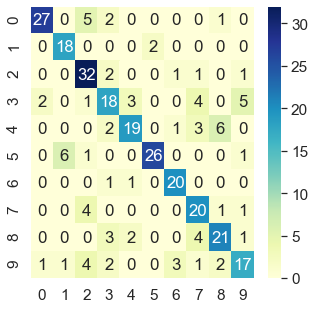

In [35]:
y_pred=best_clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu',ax=ax)
plt.savefig("CM_KNN.jpg",format='jpg')

In [36]:
print('Acurácia Treino: ',best_clf.score(X_train, y_train))
print('Acurácia Teste: ',best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  1.0
Acurácia Teste:  0.7266666666666667
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        35
           1       0.72      0.90      0.80        20
           2       0.68      0.86      0.76        37
           3       0.60      0.55      0.57        33
           4       0.76      0.61      0.68        31
           5       0.93      0.76      0.84        34
           6       0.80      0.91      0.85        22
           7       0.61      0.77      0.68        26
           8       0.68      0.68      0.68        31
           9       0.65      0.55      0.60        31

    accuracy                           0.73       300
   macro avg       0.73      0.74      0.73       300
weighted avg       0.74      0.73      0.73       300

f1_score:  0.7250604547069228


### Árvores de Decisão

In [37]:
pipe = Pipeline([('norm', StandardScaler()),('sel_feat', SelectKBest(score_func=f_classif)),('pca',PCA()),
                 ('classifier' ,DecisionTreeClassifier())])
param_grid = [
    {'sel_feat__k':[150,120,80, 60,30],
     'classifier' : [DecisionTreeClassifier()],
     'classifier__criterion' : ['gini','entropy']}]

# Create grid search object
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
clf = GridSearchCV(pipe, param_grid = param_grid, cv = cv, scoring='accuracy', verbose=True, n_jobs=-1)

# Fit on data
best_clf = clf.fit(X_train, y_train)
print("Parâmetros escolhidos ",best_clf.best_params_)
print(" Acurácia:",best_clf.best_score_)

Fitting 15 folds for each of 10 candidates, totalling 150 fits
Parâmetros escolhidos  {'classifier': DecisionTreeClassifier(criterion='entropy'), 'classifier__criterion': 'entropy', 'sel_feat__k': 60}
 Acurácia: 0.48353203151764307


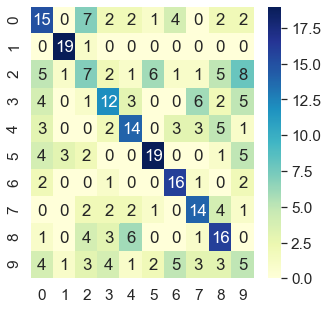

In [38]:
y_pred=best_clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu',ax=ax)
plt.savefig("CM_AD.jpg",format='jpg')

In [39]:
print('Acurácia Treino: ',best_clf.score(X_train, y_train))
print('Acurácia Teste: ',best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  1.0
Acurácia Teste:  0.45666666666666667
              precision    recall  f1-score   support

           0       0.39      0.43      0.41        35
           1       0.79      0.95      0.86        20
           2       0.26      0.19      0.22        37
           3       0.43      0.36      0.39        33
           4       0.48      0.45      0.47        31
           5       0.66      0.56      0.60        34
           6       0.55      0.73      0.63        22
           7       0.48      0.54      0.51        26
           8       0.42      0.52      0.46        31
           9       0.17      0.16      0.17        31

    accuracy                           0.46       300
   macro avg       0.46      0.49      0.47       300
weighted avg       0.45      0.46      0.45       300

f1_score:  0.4476400403813458


### Random Forest

In [41]:

pipe = Pipeline([('norm', StandardScaler()),('sel_feat', SelectKBest(score_func=f_classif)),('pca',PCA()),
                 ('classifier' ,RandomForestClassifier())])
# Create param grid.

param_grid = [
    {'sel_feat__k':[150,120,80, 60,30],
     'classifier' : [RandomForestClassifier()],
     'classifier__criterion' : ['gini','entropy'],
     'classifier__n_estimators':[100, 500, 1000, 4000]
     #'classifier__max_depth':[int(x) for x in np.linspace(1, 100, 7)],
     #'classifier__min_samples_split':[int(x) for x in np.linspace(1,15,3)]
    }]

# Create grid search object
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
clf = GridSearchCV(pipe, param_grid = param_grid, cv = cv, scoring='f1_weighted', verbose=True, n_jobs=-1)

# Fit on data
best_clf = clf.fit(X_train, y_train)
print("Parâmetros escolhidos ",best_clf.best_params_)
print(" Acurácia:",best_clf.best_score_)

Fitting 15 folds for each of 40 candidates, totalling 600 fits
Parâmetros escolhidos  {'classifier': RandomForestClassifier(n_estimators=4000), 'classifier__criterion': 'gini', 'classifier__n_estimators': 4000, 'sel_feat__k': 80}
 Acurácia: 0.7306632189838339


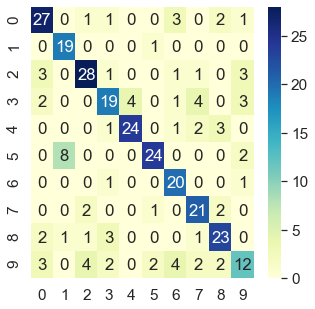

In [42]:
y_pred=best_clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu',ax=ax)
plt.savefig("CM_RF.jpg",format='jpg')

In [43]:
print('Acurácia Treino: ',best_clf.score(X_train, y_train))
print('Acurácia Teste: ',best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  1.0
Acurácia Teste:  0.7177360659948588
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        35
           1       0.68      0.95      0.79        20
           2       0.78      0.76      0.77        37
           3       0.68      0.58      0.62        33
           4       0.86      0.77      0.81        31
           5       0.86      0.71      0.77        34
           6       0.67      0.91      0.77        22
           7       0.68      0.81      0.74        26
           8       0.72      0.74      0.73        31
           9       0.55      0.39      0.45        31

    accuracy                           0.72       300
   macro avg       0.72      0.74      0.72       300
weighted avg       0.72      0.72      0.72       300

f1_score:  0.7177360659948588


### AdaBoost

In [45]:
pipe = Pipeline([('norm', StandardScaler()),('sel_feat', SelectKBest(score_func=f_classif)),('pca',PCA()),
                 ('classifier' ,AdaBoostClassifier())])
# Create param grid.

param_grid = [
    {'sel_feat__k':[120,80, 60,30],
     'classifier' : [AdaBoostClassifier()],
     'classifier__n_estimators':[50, 100, 500],
     'classifier__learning_rate':np.arange(0.1, 2, 0.3)}]

# Create grid search object
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
clf = GridSearchCV(pipe, param_grid = param_grid, cv = cv, scoring='f1_weighted', verbose=True, n_jobs=-1)

# Fit on data
best_clf = clf.fit(X_train, y_train)
print("hpyer-parâmetros :(melhores parametros) ",best_clf.best_params_)
print("acurácia :",best_clf.best_score_)

Fitting 15 folds for each of 84 candidates, totalling 1260 fits
hpyer-parâmetros :(melhores parametros)  {'classifier': AdaBoostClassifier(learning_rate=1.9000000000000004, n_estimators=500), 'classifier__learning_rate': 1.9000000000000004, 'classifier__n_estimators': 500, 'sel_feat__k': 60}
acurácia : 0.49243552184477934


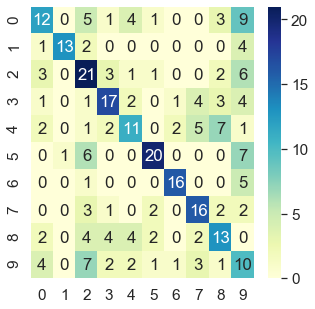

In [46]:
y_pred=best_clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu',ax=ax)

In [47]:
print('Acurácia Treino: ',best_clf.score(X_train, y_train))
print('Acurácia Teste: ',best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  0.7244229382821625
Acurácia Teste:  0.5064165440591902
              precision    recall  f1-score   support

           0       0.48      0.34      0.40        35
           1       0.93      0.65      0.76        20
           2       0.41      0.57      0.48        37
           3       0.57      0.52      0.54        33
           4       0.46      0.35      0.40        31
           5       0.74      0.59      0.66        34
           6       0.80      0.73      0.76        22
           7       0.53      0.62      0.57        26
           8       0.42      0.42      0.42        31
           9       0.21      0.32      0.25        31

    accuracy                           0.50       300
   macro avg       0.55      0.51      0.52       300
weighted avg       0.53      0.50      0.51       300

f1_score:  0.5064165440591902


### Gradient Boost

In [49]:

pipe = Pipeline([('norm', StandardScaler()),('sel_feat', SelectKBest(score_func=f_classif)),('pca',PCA()),
                 ('classifier' ,GradientBoostingClassifier())])
# Create param grid.

param_grid = [
    {'sel_feat__k':[150,120,80, 60,30],
     'classifier' : [GradientBoostingClassifier()],
     'classifier__n_estimators':[50, 100, 500],
     'classifier__learning_rate':np.arange(0.1, 2.1, 0.4)
     #'classifier__min_samples_split': np.linspace(0.1, 0.5, 3),
     #'classifier__min_samples_leaf': np.linspace(0.1, 0.5, 3)
    }]

# Create grid search object
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)
clf = GridSearchCV(pipe, param_grid = param_grid, cv = cv, scoring='f1_weighted', verbose=True, n_jobs=-1)

# Fit on data
best_clf = clf.fit(X_train, y_train)
print("Parâmetros escolhidos ",best_clf.best_params_)
print(" Acurácia:",best_clf.best_score_)

Fitting 6 folds for each of 75 candidates, totalling 450 fits
Parâmetros escolhidos  {'classifier': GradientBoostingClassifier(learning_rate=0.5, n_estimators=500), 'classifier__learning_rate': 0.5, 'classifier__n_estimators': 500, 'sel_feat__k': 30}
 Acurácia: 0.6097312773884324


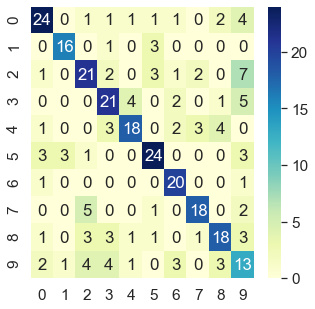

In [50]:
y_pred=best_clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu',ax=ax)
plt.savefig("CM_GB.jpg",format='jpg')

In [51]:
print('Acurácia Treino: ',best_clf.score(X_train, y_train))
print('Acurácia Teste: ',best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  1.0
Acurácia Teste:  0.6450988820986953
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        35
           1       0.80      0.80      0.80        20
           2       0.60      0.57      0.58        37
           3       0.60      0.64      0.62        33
           4       0.72      0.58      0.64        31
           5       0.73      0.71      0.72        34
           6       0.69      0.91      0.78        22
           7       0.75      0.69      0.72        26
           8       0.64      0.58      0.61        31
           9       0.34      0.42      0.38        31

    accuracy                           0.64       300
   macro avg       0.66      0.66      0.66       300
weighted avg       0.65      0.64      0.65       300

f1_score:  0.6450988820986953


### XGBoost

In [52]:

pipe = Pipeline([('norm', StandardScaler()),('sel_feat', SelectKBest(score_func=f_classif)),('pca',PCA()),
                 ('classifier' ,xgb.XGBClassifier())])

param_grid = [
    {'sel_feat__k':[150,120,80, 60,30],
     'classifier' : [xgb.XGBClassifier()],
     #'classifier__min_child_weight': [1, 5, 10],
     'classifier__gamma': [0.5, 1, 5],
     #'classifier__subsample': [0.6, 0.8, 1.0],
     #'classifier__colsample_bytree': [0.6, 0.8, 1.0],
     #'classifier__max_depth': [3, 4, 5]
    }]

# Create grid search object
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
clf = GridSearchCV(pipe, param_grid = param_grid, cv = cv, scoring='f1_weighted', verbose=True, n_jobs=-1)

# Fit on data
best_clf = clf.fit(X_train, y_train)
print("hpyer-parâmetros :(melhores parametros) ",best_clf.best_params_)
print("acurácia :",best_clf.best_score_)

Fitting 15 folds for each of 15 candidates, totalling 225 fits
[13:25:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
hpyer-parâmetros :(melhores parametros)  {'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=0.5,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=N

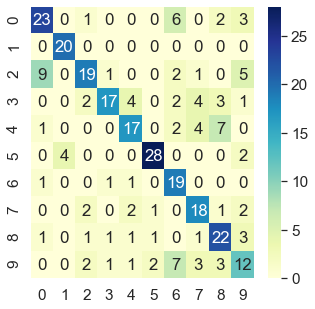

In [53]:
y_pred=best_clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu',ax=ax)
plt.savefig("CM_XGB.jpg",format='jpg')

In [54]:
print('Acurácia Treino: ',best_clf.score(X_train, y_train))
print('Acurácia Teste: ',best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  1.0
Acurácia Teste:  0.6466691009224098
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        35
           1       0.83      1.00      0.91        20
           2       0.70      0.51      0.59        37
           3       0.81      0.52      0.63        33
           4       0.65      0.55      0.60        31
           5       0.88      0.82      0.85        34
           6       0.50      0.86      0.63        22
           7       0.58      0.69      0.63        26
           8       0.58      0.71      0.64        31
           9       0.43      0.39      0.41        31

    accuracy                           0.65       300
   macro avg       0.66      0.67      0.65       300
weighted avg       0.67      0.65      0.65       300

f1_score:  0.6466691009224098


### SVM

In [55]:

pipe = Pipeline([('norm', StandardScaler()),('sel_feat', SelectKBest(score_func=f_classif)),('pca',PCA()),
                 ('classifier' ,SVC())])
# Create param grid.

param_grid = [
    {'sel_feat__k':[150,120,80, 60,30],
     'classifier' : [SVC()],
     'classifier__C':[1,10,100,1000],
     'classifier__gamma':[1,0.1,0.001,0.0001],
     'classifier__kernel':['linear','rbf','poly','sigmoid']
    }]

# Create grid search object
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
clf = GridSearchCV(pipe, param_grid = param_grid, cv = cv, scoring='f1_weighted', verbose=True, n_jobs=-1)

# Fit on data
best_clf = clf.fit(X_train, y_train)
print("Parâmetros escolhidos ",best_clf.best_params_)
print(" Acurácia:",best_clf.best_score_)

Fitting 15 folds for each of 320 candidates, totalling 4800 fits
Parâmetros escolhidos  {'classifier': SVC(C=100, gamma=0.001), 'classifier__C': 100, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'sel_feat__k': 60}
 Acurácia: 0.762493654909051


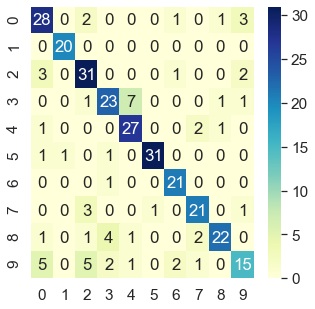

In [56]:
y_pred=best_clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu',ax=ax)
plt.savefig("CM_SVM.jpg",format='jpg')

In [57]:
print('Acurácia Treino: ',best_clf.score(X_train, y_train))
print('Acurácia Teste: ',best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print("f1_score: ",f1_score(y_test,y_pred,average='weighted'))

Acurácia Treino:  0.9539882219847395
Acurácia Teste:  0.7929359577041534
              precision    recall  f1-score   support

           0       0.72      0.80      0.76        35
           1       0.95      1.00      0.98        20
           2       0.72      0.84      0.77        37
           3       0.74      0.70      0.72        33
           4       0.75      0.87      0.81        31
           5       0.97      0.91      0.94        34
           6       0.84      0.95      0.89        22
           7       0.81      0.81      0.81        26
           8       0.88      0.71      0.79        31
           9       0.68      0.48      0.57        31

    accuracy                           0.80       300
   macro avg       0.81      0.81      0.80       300
weighted avg       0.80      0.80      0.79       300

f1_score:  0.7929359577041534
